# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [55]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2015-09-28/data_eval_new/"
file_name = "int_norm_20150929_bgd_new_den.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [56]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [57]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [58]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

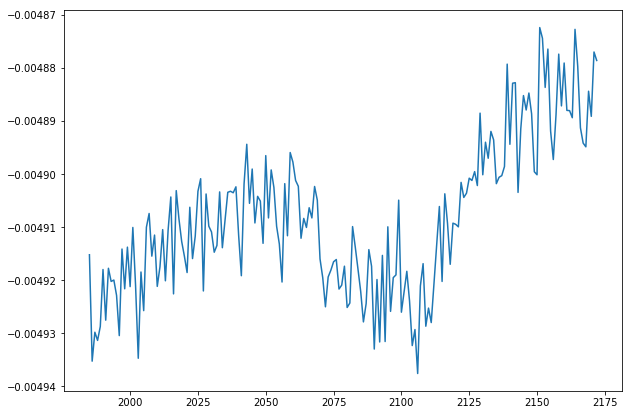

In [59]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

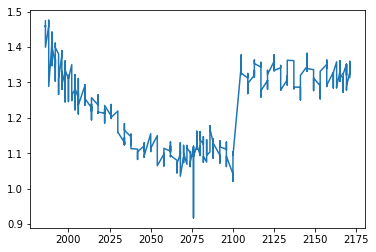

In [60]:
# Check Signals
column = "122"
sample = "NIST 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

In [61]:
df_mean(signals[signals["Sample"] != "blank sol"])["Sample"].unique()

array(['NIST 100ppb', 'NIST 100ppb + Te 0.1ppb',
       'NIST 100ppb + Cd 0.01ppb', 'NIST 100ppb + U 0.001ppb',
       'NIST 100ppb + Te 0.2ppb', 'NIST 100ppb + Cd 0.02ppb',
       'NIST 100ppb + U 0.003ppb', 'NIST 100ppb + Te 0.5ppb',
       'NIST 100ppb + Cd 0.03ppb', 'NIST 100ppb + U 0.005ppb',
       'NIST 100ppb + Te 1ppb', 'NIST 100ppb + Cd 0.05ppb',
       'NIST 100ppb + U 0.01ppb', 'NIST 100ppb + Te 1.5ppb',
       'NIST 100ppb + Cd 0.07ppb', 'NIST 100ppb + Te 2ppb'], dtype=object)

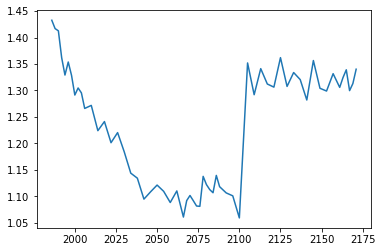

In [62]:
# Check Signals - mean
column = "122"
sample = "NIST 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

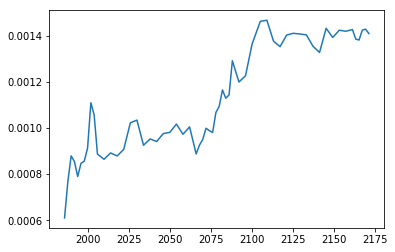

In [63]:
# Check background 
column = "118"
sample = "NIST 100ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [64]:
background_mean = df_mean(background)

In [65]:
# Create Dataframe for signals_bgd corr
signals["Te/Sn"] = (signals["125_2"]/7.050686)/(signals["118"]/24.223)
signals["Cd/Sn"] = (signals["111"]/12.9447)/(signals["118"]/24.223)

In [66]:
signals_mean = signals.groupby("Filenumber").agg("mean")

# Outlier rejection

In [67]:
bgd_method = 'bgd_outlier_corr' #'no_bgd_corr'
norm_ratio = "r_116_120"
interf_corr = "Te125_Xe129_corr"

In [68]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [69]:
column = "124/120"
sample = "NIST 100ppb"

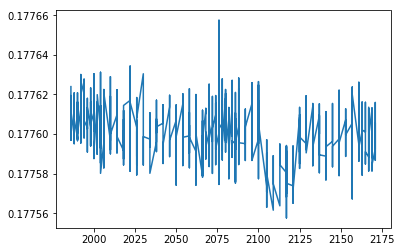

In [70]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [71]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


In [72]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2015-09-28 21:43:00,NIST 100ppb,2,1,1986,0.029819,0.020192,0.010356,0.446,0.235274,0.742900,0.263453,0.142095,0.177624
2015-09-28 21:43:00,NIST 100ppb,2,2,1986,0.029834,0.020195,0.010356,0.446,0.235297,0.742916,0.263457,0.142105,0.177611
2015-09-28 21:43:00,NIST 100ppb,2,3,1986,0.029831,0.020191,0.010352,0.446,0.235289,0.742915,0.263461,0.142091,0.177607
2015-09-28 21:43:00,NIST 100ppb,2,4,1986,0.029821,0.020186,0.010353,0.446,0.235262,0.742871,0.263461,0.142108,0.177609
2015-09-28 21:43:00,NIST 100ppb,2,5,1986,0.029829,0.020189,0.010354,0.446,0.235291,0.742926,0.263447,0.142094,0.177610
2015-09-28 21:43:00,NIST 100ppb,2,6,1986,0.029822,0.020192,0.010356,0.446,0.235286,0.742890,0.263462,0.142106,0.177605
2015-09-28 21:43:00,NIST 100ppb,2,7,1986,0.029831,0.020192,0.010358,0.446,0.235293,0.742897,0.263451,0.142102,0.177598
2015-09-28 21:43:00,NIST 100ppb,2,8,1986,0.029830,0.020192,0.010355,0.446,0.235283,0.742903,0.263454,0.142092,0.177597
2015-09-28 21:43:00,NIST 100ppb,2,9,1986,0.029826,0.020190,0.010357,0.446,0.235289,0.742913,0.263464,0.142106,0.177610


In [73]:
df_outlier_int[df_outlier_int[column].notnull()][column]

Filenumber  Date               
2022        2015-09-29 04:34:00    0.177634
2030        2015-09-29 06:04:00    0.177630
            2015-09-29 06:04:00    0.177624
2032        2015-09-29 06:27:00    0.177583
2034        2015-09-29 06:49:00    0.177580
2038        2015-09-29 07:35:00    0.177591
            2015-09-29 07:35:00    0.177617
2050        2015-09-29 09:52:00    0.177574
2062        2015-09-29 12:12:00    0.177574
2076        2015-09-29 14:51:00    0.177650
            2015-09-29 14:51:00    0.177657
2137        2015-09-30 03:27:00    0.177580
2157        2015-09-30 07:11:00    0.177567
2161        2015-09-30 07:56:00    0.177626
Name: 124/120, dtype: float64

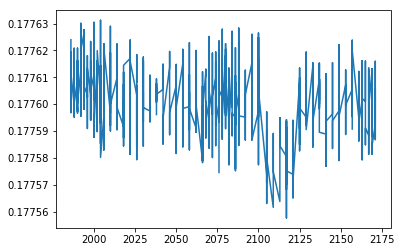

In [74]:
# Check sample measurements
df = df_outlier_rej_int

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [75]:
df[df["Sample"] == sample][column].std()

1.1655103082737597e-05

In [76]:
df_outlier_rej_int["Cd/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Cd/Sn"]
df_outlier_rej_int["Te/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Te/Sn"]

In [77]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

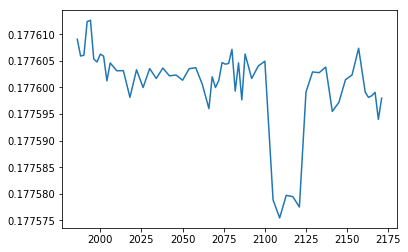

In [78]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [79]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Cd/Sn,Te/Sn
Date,,,,,,,,,,,,,
2015-09-28 21:43:00,1986,NIST 100ppb,0.029826,0.020192,0.010356,0.446,0.235285,0.742909,0.263458,0.142103,0.177609,0.000012,0.000017
2015-09-28 22:06:00,1988,NIST 100ppb,0.029827,0.020196,0.010357,0.446,0.235293,0.742906,0.263455,0.142104,0.177606,0.000010,0.000022
2015-09-28 22:29:00,1990,NIST 100ppb,0.029826,0.020194,0.010357,0.446,0.235292,0.742904,0.263456,0.142103,0.177606,0.000010,0.000019
2015-09-28 22:52:00,1992,NIST 100ppb,0.029829,0.020192,0.010359,0.446,0.235296,0.742910,0.263456,0.142107,0.177612,0.000010,0.000020
2015-09-28 23:14:00,1994,NIST 100ppb,0.029829,0.020192,0.010359,0.446,0.235293,0.742913,0.263456,0.142105,0.177613,0.000013,0.000019
2015-09-28 23:37:00,1996,NIST 100ppb,0.029833,0.020199,0.010359,0.446,0.235296,0.742906,0.263453,0.142102,0.177605,0.000007,0.000019
2015-09-29 00:00:00,1998,NIST 100ppb,0.029828,0.020195,0.010360,0.446,0.235290,0.742904,0.263454,0.142105,0.177605,0.000011,0.000025
2015-09-29 00:23:00,2000,NIST 100ppb,0.029827,0.020196,0.010358,0.446,0.235295,0.742907,0.263450,0.142104,0.177606,0.000010,0.000026
2015-09-29 00:45:00,2002,NIST 100ppb,0.029832,0.020199,0.010359,0.446,0.235298,0.742905,0.263454,0.142103,0.177606,0.000009,0.000027


In [80]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [81]:
drop_sum = []

In [82]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [83]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [84]:
data_mean_int_sum

112/120                       114/120  \
                              mean           SD2 count      mean   
Sample                                                             
NIST 100ppb               0.029830  5.827332e-06    60  0.020196   
NIST 100ppb + Cd 0.01ppb  0.029830  1.012911e-05     3  0.020199   
NIST 100ppb + Cd 0.02ppb  0.029833  5.881947e-06     2  0.020200   
NIST 100ppb + Cd 0.03ppb  0.029831  7.781799e-06     2  0.020199   
NIST 100ppb + Cd 0.05ppb  0.029831  3.021836e-06     2  0.020201   
NIST 100ppb + Cd 0.07ppb  0.029831  5.360223e-06     2  0.020204   
NIST 100ppb + Te 0.1ppb   0.029827  5.484374e-06     3  0.020196   
NIST 100ppb + Te 0.2ppb   0.029828  1.727613e-06     2  0.020196   
NIST 100ppb + Te 0.5ppb   0.029827  8.786152e-07     2  0.020194   
NIST 100ppb + Te 1.5ppb   0.029830  7.756966e-07     2  0.020198   
NIST 100ppb + Te 1ppb     0.029833  4.748244e-06     2  0.020200   
NIST 100ppb + Te 2ppb     0.029826  1.993107e-06     2  0.020194   
NIST 100ppb + U 0.001ppb  0.029828  7.039594e-06     3  0.020197   
NIST 100ppb + U 0.003ppb  0.029829  3.710773e-06     2  0.020195   
NIST 100ppb + U 0.005ppb  0.029830  7.283697e-07     2  0.020197   
NIST 100ppb + U 0.01ppb   0.029833  9.625612e-06     2  0.020197   

                                               115/120                      \
                                   SD2 count      mean           SD2 count   
Sample                                                                       
NIST 100ppb               6.660606e-06    60  0.010360  2.829677e-06    60   
NIST 100ppb + Cd 0.01ppb  1.962859e-06     3  0.010361  1.531179e-06     3   
NIST 100ppb + Cd 0.02ppb  2.515790e-06     2  0.010360  2.641000e-06     2   
NIST 100ppb + Cd 0.03ppb  9.085566e-06     2  0.010360  4.676393e-07     2   
NIST 100ppb + Cd 0.05ppb  5.743959e-06     2  0.010361  5.362356e-06     2   
NIST 100ppb + Cd 0.07ppb  2.235159e-06     2  0.010359  1.833270e-07     2   
NIST 100ppb + Te 0.1ppb   3.378453e-06     3  0.010361  2.640450e-06     3   
NIST 100ppb + Te 0.2ppb   1.707134e-06     2  0.010360  1.989559e-06     2   
NIST 100ppb + Te 0.5ppb   5.026525e-06     2  0.010360  4.761607e-06     2   
NIST 100ppb + Te 1.5ppb   1.713410e-06     2  0.010359  2.535591e-06     2   
NIST 100ppb + Te 1ppb     2.124355e-06     2  0.010358  5.304610e-07     2   
NIST 100ppb + Te 2ppb     1.594484e-06     2  0.010360  1.212355e-06     2   
NIST 100ppb + U 0.001ppb  4.705834e-06     3  0.010360  1.254546e-06     3   
NIST 100ppb + U 0.003ppb  5.054703e-06     2  0.010361  1.367997e-06     2   
NIST 100ppb + U 0.005ppb  9.481633e-07     2  0.010359  8.714973e-07     2   
NIST 100ppb + U 0.01ppb   3.553402e-06     2  0.010360  1.574274e-06     2   

                         116/120  ...  122/120   124/120                      \
                            mean  ...    count      mean           SD2 count   
Sample                            ...                                          
NIST 100ppb                0.446  ...       60  0.177601  1.538992e-05    60   
NIST 100ppb + Cd 0.01ppb   0.446  ...        3  0.177595  2.341836e-05     3   
NIST 100ppb + Cd 0.02ppb   0.446  ...        2  0.177592  3.717037e-05     2   
NIST 100ppb + Cd 0.03ppb   0.446  ...        2  0.177594  2.013702e-05     2   
NIST 100ppb + Cd 0.05ppb   0.446  ...        2  0.177602  5.671099e-06     2   
NIST 100ppb + Cd 0.07ppb   0.446  ...        2  0.177603  3.979070e-06     2   
NIST 100ppb + Te 0.1ppb    0.446  ...        3  0.177597  3.119827e-05     3   
NIST 100ppb + Te 0.2ppb    0.446  ...        2  0.177595  3.036036e-05     2   
NIST 100ppb + Te 0.5ppb    0.446  ...        2  0.177605  1.019925e-05     2   
NIST 100ppb + Te 1.5ppb    0.446  ...        2  0.177603  5.795154e-07     2   
NIST 100ppb + Te 1ppb      0.446  ...        2  0.177601  5.129603e-06     2   
NIST 100ppb + Te 2ppb      0.446  ...        2  0.177601  2.239279e-06     2   
NIST 100ppb + U 0.001ppb   0.446  ...        3  0.1

In [85]:
date_list = []

epsilon_int_NIST = SSB(data_mean_int.drop(date_list), "NIST 100ppb", 10000)
delta_raw_NIST = SSB(data_mean_raw.drop(date_list), "NIST 100ppb", 1000)

In [86]:
epsilon_int_NIST = epsilon_int_NIST.drop(["Cd/Sn", "Te/Sn"], axis=1)

In [87]:
epsilon_int_NIST[epsilon_int_NIST["Filenumber"] > 1]

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2015-09-29 12:57:00,4.842615,-1.088073,-3.989120,0.956862,0.000000e+00,0.034385,0.210747,0.224982,-0.043986,-0.296030,NIST 100ppb
2015-09-29 21:05:00,2.378121,-0.826398,0.391366,-1.292304,0.000000e+00,0.117232,0.217893,0.347433,-0.227924,-0.736344,NIST 100ppb + Te 0.1ppb
2015-09-29 21:27:00,2.375861,-1.164825,-0.171349,-1.171881,0.000000e+00,0.214393,0.231160,0.237719,-0.486640,-0.638483,NIST 100ppb
2015-09-30 07:56:00,4.629630,-0.110504,0.735919,-0.167750,2.220446e-12,0.009290,-0.039727,0.041027,0.052686,-0.203743,NIST 100ppb


In [88]:

date_list = []

epsilon_int_NIST = epsilon_int_NIST.drop(date_list)
delta_raw_NIST = delta_raw_NIST.drop(date_list)

In [89]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -1) & (df["Filenumber"] <= 1)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [90]:
epsilon_int_NIST = epsilon_process(epsilon_int_NIST)
delta_raw_NIST = epsilon_process(delta_raw_NIST)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [91]:
epsilon_int_NIST

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2015-09-28 22:06:00,1988,0.409821,1.506744,0.435592,2.220446e-12,0.185241,-0.005868,-0.082320,0.087175,-0.093065,NIST 100ppb
2015-09-28 22:29:00,1990,-0.857665,-0.060766,-0.596396,-1.110223e-12,-0.120821,-0.051273,0.030084,-0.173323,-0.173718,NIST 100ppb
2015-09-28 22:52:00,1992,0.588535,-0.474906,0.903159,2.220446e-12,0.173061,0.014494,0.000241,0.173032,0.170417,NIST 100ppb
2015-09-28 23:14:00,1994,-0.640117,-1.663876,-0.266395,0.000000e+00,-0.151102,0.072075,0.042552,0.058890,0.212448,NIST 100ppb
2015-09-28 23:37:00,1996,1.424964,2.748602,-0.370192,0.000000e+00,0.203556,-0.033669,-0.058663,-0.207362,-0.189369,NIST 100ppb
2015-09-29 00:00:00,1998,-0.719620,-1.385718,1.351694,2.220446e-12,-0.231624,-0.033548,0.083374,0.164094,-0.057271,NIST 100ppb
2015-09-29 00:23:00,2000,-0.895075,-0.354756,-1.509337,-1.110223e-12,0.045768,0.028750,-0.146653,-0.042838,0.052524,NIST 100ppb
2015-09-29 00:45:00,2002,1.439107,2.153665,0.999809,2.220446e-12,-0.014829,-0.086899,0.085197,-0.016527,0.119566,NIST 100ppb
2015-09-29 01:07:00,2004,-0.859397,-2.119717,-0.545195,0.000000e+00,0.223578,0.076913,-0.012566,-0.080940,-0.225209,NIST 100ppb


In [92]:
epsilon_NIST_sum = np.round(epsilon_int_NIST.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_sum = np.round(delta_raw_NIST.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_NIST_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_NIST_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [93]:
epsilon_sum_all

112/120              114/120              115/120  \
                            mean    SD2 count    mean    SD2 count    mean   
Sample                                                                       
NIST 100ppb                0.036  1.985    52   0.070  3.465    52  -0.057   
NIST 100ppb + Cd 0.01ppb   0.210  0.367     3   1.482  2.645     3   0.984   
NIST 100ppb + Cd 0.02ppb   1.192  0.232     2   1.691  0.836     2  -0.325   
NIST 100ppb + Cd 0.03ppb  -0.433  2.212     2  -0.295  5.339     2   0.737   
NIST 100ppb + Cd 0.05ppb   0.849  0.307     2   3.487  1.810     2  -0.634   
NIST 100ppb + Cd 0.07ppb  -0.141  0.368     2   3.245  5.464     2  -1.081   
NIST 100ppb + Te 0.1ppb   -0.595  0.329     2  -0.131  1.089     2   1.538   
NIST 100ppb + Te 0.2ppb   -0.391  1.757     2  -0.541  1.639     2  -0.370   
NIST 100ppb + Te 0.5ppb   -1.356  1.322     2  -1.385  3.750     2   0.673   
NIST 100ppb + Te 1.5ppb    0.203  0.765     2   1.829  0.312     2  -0.943   
NIST 100ppb + Te 1ppb      0.889  1.991     2   1.573  1.093     2  -2.692   
NIST 100ppb + Te 2ppb     -1.443  0.773     2  -1.498  0.942     2  -0.448   
NIST 100ppb + U 0.001ppb  -0.437  2.034     3   0.695  2.939     3  -0.133   
NIST 100ppb + U 0.003ppb  -0.357  3.219     2  -0.514  3.881     2   0.727   
NIST 100ppb + U 0.005ppb  -0.838  1.569     2  -2.197  0.186     2  -0.073   
NIST 100ppb + U 0.01ppb    1.571  3.090     2   1.788  2.319     2  -0.455   

                                      116/120  ...  118/120 119/120         \
                            SD2 count    mean  ...    count    mean    SD2   
Sample                                         ...                           
NIST 100ppb               2.664    52     0.0  ...       52  -0.008  0.217   
NIST 100ppb + Cd 0.01ppb  0.957     3     0.0  ...        3   0.000  0.102   
NIST 100ppb + Cd 0.02ppb  6.263     2     0.0  ...        2   0.128  0.048   
NIST 100ppb + Cd 0.03ppb  0.756     2     0.0  ...        2  -0.166  0.129   
NIST 100ppb + Cd 0.05ppb  4.742     2     0.0  ...        2   0.138  0.072   
NIST 100ppb + Cd 0.07ppb  1.229     2     0.0  ...        2  -0.059  0.072   
NIST 100ppb + Te 0.1ppb   0.885     2     0.0  ...        2  -0.063  0.236   
NIST 100ppb + Te 0.2ppb   1.107     2     0.0  ...        2  -0.037  0.047   
NIST 100ppb + Te 0.5ppb   4.457     2     0.0  ...        2  -0.038  0.053   
NIST 100ppb + Te 1.5ppb   2.310     2    -0.0  ...        2   0.115  0.239   
NIST 100ppb + Te 1ppb     2.074     2     0.0  ...        2  -0.063  0.283   
NIST 100ppb + Te 2ppb     0.590     2     0.0  ...        2  -0.128  0.308   
NIST 100ppb + U 0.001ppb  1.839     3     0.0  ...        3  -0.050  0.305   
NIST 100ppb + U 0.003ppb  2.633     2     0.0  ...        2  -0.159  0.644   
NIST 100ppb + U 0.005ppb  0.641     2     0.0  ...        2   0.050  0.164   
NIST 100ppb + U 0.01ppb   0.223     2     0.0  ...        2   0.147  0.099   

                               122/120              124/120               
                         count    mean    SD2 count    mean    SD2 count  
Sample                                                                    
NIST 100ppb                 52  -0.005  0.329    52  -0.006  0.426    52  
NIST 100ppb + Cd 0.01ppb     3   0.091  0.511     3   0.040  0.368     3  
NIST 100ppb + Cd 0.02ppb     2  -0.025  0.052     2   0.134  0.250     2  
NIST 100ppb + Cd 0.03ppb     2  -0.260  1.451     2  -0.512  1.120     2  
NIST 100ppb + Cd 0.05ppb     2   0.157  0.428     2   0.181  0.119     2  
NIST 100ppb + Cd 0.07ppb     2  -0.001  0.073     2  -0.048  0.440     2  
NIST 100ppb + Te 0.1ppb      2   0.085  0.778     2   0.098  0.277     2  
NIST 100ppb + Te 0.2ppb      2   0.008  0.155     2   0.251  0.027     2  
NIST 100ppb + Te 0.5ppb      2  -0.002  0.045     2   0.163  0.448     2  
NIST 100ppb + Te 1.5ppb      2  -0.114  0.051     2  -0.007  0.104     2  
NIST 100ppb + Te 1ppb        2  -0.064  0.048     2   0.005  0.082     2  
NIST 100p

In [94]:
delta_raw_sum_all

112/120              114/120              115/120  \
                            mean    SD2 count    mean    SD2 count    mean   
Sample                                                                       
NIST 100ppb               -0.004  1.562    58  -0.001  1.165    58  -0.003   
NIST 100ppb + Cd 0.01ppb   0.215  0.443     3   0.290  0.560     3   0.216   
NIST 100ppb + Cd 0.02ppb   0.248  0.161     2   0.270  0.055     2   0.037   
NIST 100ppb + Cd 0.03ppb   0.053  0.259     2   0.046  0.574     2   0.133   
NIST 100ppb + Cd 0.05ppb   0.162  0.031     2   0.408  0.176     2  -0.024   
NIST 100ppb + Cd 0.07ppb  -0.175  0.266     2   0.212  0.396     2  -0.195   
NIST 100ppb + Te 0.1ppb    0.897  3.650     3   0.706  2.819     3   0.624   
NIST 100ppb + Te 0.2ppb    0.076  0.107     2   0.035  0.408     2   0.037   
NIST 100ppb + Te 0.5ppb   -0.025  0.401     2  -0.064  0.021     2   0.144   
NIST 100ppb + Te 1.5ppb   -0.028  0.251     2   0.137  0.111     2  -0.115   
NIST 100ppb + Te 1ppb     -0.109  0.418     2   0.037  0.305     2  -0.395   
NIST 100ppb + Te 2ppb     -0.019  0.225     2  -0.047  0.011     2   0.046   
NIST 100ppb + U 0.001ppb  -0.075  0.188     3   0.046  0.166     3  -0.025   
NIST 100ppb + U 0.003ppb  -1.446  4.074     2  -1.120  2.773     2  -0.834   
NIST 100ppb + U 0.005ppb   0.071  0.433     2  -0.099  0.203     2   0.052   
NIST 100ppb + U 0.01ppb    0.221  0.576     2   0.217  0.423     2   0.003   

                                      116/120  ...  118/120 119/120         \
                            SD2 count    mean  ...    count    mean    SD2   
Sample                                         ...                           
NIST 100ppb               0.930    58  -0.003  ...       58  -0.001  0.205   
NIST 100ppb + Cd 0.01ppb  0.254     3   0.092  ...        3   0.024  0.063   
NIST 100ppb + Cd 0.02ppb  0.770     2   0.054  ...        2   0.025  0.020   
NIST 100ppb + Cd 0.03ppb  0.099     2   0.055  ...        2  -0.003  0.024   
NIST 100ppb + Cd 0.05ppb  0.411     2   0.035  ...        2   0.022  0.004   
NIST 100ppb + Cd 0.07ppb  0.265     2  -0.074  ...        2  -0.026  0.012   
NIST 100ppb + Te 0.1ppb   2.004     3   0.464  ...        3   0.125  0.494   
NIST 100ppb + Te 0.2ppb   0.313     2   0.068  ...        2   0.011  0.046   
NIST 100ppb + Te 0.5ppb   0.799     2   0.058  ...        2   0.006  0.049   
NIST 100ppb + Te 1.5ppb   0.363     2  -0.017  ...        2   0.006  0.005   
NIST 100ppb + Te 1ppb     0.330     2  -0.088  ...        2  -0.028  0.061   
NIST 100ppb + Te 2ppb     0.008     2   0.068  ...        2   0.006  0.040   
NIST 100ppb + U 0.001ppb  0.213     3  -0.015  ...        3  -0.009  0.019   
NIST 100ppb + U 0.003ppb  2.314     2  -0.705  ...        2  -0.187  0.583   
NIST 100ppb + U 0.005ppb  0.308     2   0.076  ...        2   0.024  0.050   
NIST 100ppb + U 0.01ppb   0.161     2   0.033  ...        2   0.021  0.015   

                               122/120              124/120               
                         count    mean    SD2 count    mean    SD2 count  
Sample                                                                    
NIST 100ppb                 58   0.001  0.402    58   0.002  0.795    58  
NIST 100ppb + Cd 0.01ppb     3  -0.034  0.075     3  -0.087  0.190     3  
NIST 100ppb + Cd 0.02ppb     2  -0.030  0.038     2  -0.038  0.117     2  
NIST 100ppb + Cd 0.03ppb     2  -0.053  0.135     2  -0.095  0.090     2  
NIST 100ppb + Cd 0.05ppb     2  -0.001  0.048     2  -0.017  0.007     2  
NIST 100ppb + Cd 0.07ppb     2   0.037  0.055     2   0.072  0.055     2  
NIST 100ppb + Te 0.1ppb      3  -0.225  0.930     3  -0.469  1.867     3  
NIST 100ppb + Te 0.2ppb      2  -0.028  0.063     2  -0.041  0.140     2  
NIST 100ppb + Te 0.5ppb      2  -0.035  0.110     2  -0.039  0.217     2  
NIST 100ppb + Te 1.5ppb      2  -0.003  0.062     2   0.020  0.105     2  
NIST 100ppb + Te 1ppb        2   0.037  0.060     2   0.088  0.125     2  
NIST 100p

In [405]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_SPEX, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_SPEX, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [154]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [372]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [373]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [95]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_bgd_new_den.xlsx', engine='xlsxwriter')


In [96]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_NIST.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_NIST.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [97]:
writer_orig.save()

In [111]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [98]:
hdf5_file.flush()
hdf5_file.close()

In [54]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')

NameError: name 'df_DS_inv_mean_sample_sd' is not defined